# Analysis of C26:0 Levels in Males with Adrenal Insufficiency
This notebook analyzes the levels of C26:0 in males with and without adrenal insufficiency (AI). The data is sourced from the supplementary data of [Jaspers et al. (2024), *"Lipidomic biomarkers in plasma correlate with disease severity in adrenoleukodystrophy"*](https://www.nature.com/articles/s43856-024-00605-9).

The goal is to reproduce some of the results in the paper, by creating plots comparing C26:0 levels across three groups:
- Patients with no AI and younger than 55 (`NoAI`).
- Patients with no AI and older than 55 (`NoAI >55`).
- Patients with AI (`AI`).

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = '../SupplementaryData5.xlsx'
data = pd.read_excel(file_path, sheet_name='LPC26.0_data').drop(index=0)
data.head()

,Males,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Females,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,LPC(26:0) (nmol/L) at timepoints post HCT (months),Unnamed: 12,Unnamed: 13,Unnamed: 14
1,MLPC_men_001,CALD,AI,severe,567.564,NaN,MLPC_women_001,severe,439.033,NaN,HCT_001,498.150,321.766,NaN,266.726
2,MLPC_men_002,CALD,AI,na,928.313,NaN,MLPC_women_002,severe,488.742,NaN,HCT_002,521.813,NaN,334.243,NaN
3,MLPC_men_003,CALD,AI,na,902.946,NaN,MLPC_women_003,severe,166.691,NaN,HCT_003,347.304,NaN,217.629,172.835
4,MLPC_men_004,CALD,AI,severe,749.672,NaN,MLPC_women_004,severe,248.272,NaN,HCT_004,471.822,NaN,146.873,228.462
5,MLPC_men_005,CALD,AI,severe,741.871,NaN,MLPC_women_005,severe,473.138,NaN,HCT_005,364.148,404.391,329.974,NaN


In [2]:
data.shape

(103, 15)

In [8]:
np.unique(data["Unnamed: 2"].values)

array(['AI', 'HCT', 'NoAI', 'NoAI >55', 'Sample before CALD'],
      dtype=object)

## Data Cleaning
We're interested in two columns: "Presence of adrenal insufficiency" and "C26:0 µmol/L".

In [3]:
data_cleaned = data.rename(columns={
    'Males': 'Sample ID',
    'Unnamed: 2': 'Group',
    'Unnamed: 4': 'LPC(26:0) (nmol/L)'
})

# Extract relevant data for males only
male_data = data_cleaned[['Sample ID', 'Group', 'LPC(26:0) (nmol/L)']].dropna()

# Filter out "Sample before CALD" rows
male_data = male_data[~male_data['Group'].str.contains('Sample before CALD', na=False)]
# Filter out "HCT" rows
male_data = male_data[~male_data['Group'].str.contains('HCT', na=False)]

# Convert "C26:0 µmol/L" to numeric for plotting
male_data['LPC(26:0) (nmol/L)'] = pd.to_numeric(male_data['LPC(26:0) (nmol/L)'], errors='coerce')

male_data = male_data.dropna(subset=['Group', 'LPC(26:0) (nmol/L)'])
male_data.shape

(96, 3)

In [4]:
# Duplicate NoAI >55 so that they are included in AI
older_than_55 = male_data[male_data['Group'] == 'NoAI >55'].copy()
older_than_55['Group'] = older_than_55['Group'].map({'NoAI >55': 'NoAI'})
with_duplicates = pd.concat([male_data, older_than_55])

group_order = ['NoAI', 'NoAI >55', 'AI']

# Prepare data for plotting
grouped_data = [with_duplicates[with_duplicates['Group'] == group]['LPC(26:0) (nmol/L)'] for group in group_order]

## Boxplots

We can now generate boxplots and scatter plots for the three groups showing the distribution of C26:0 levels.

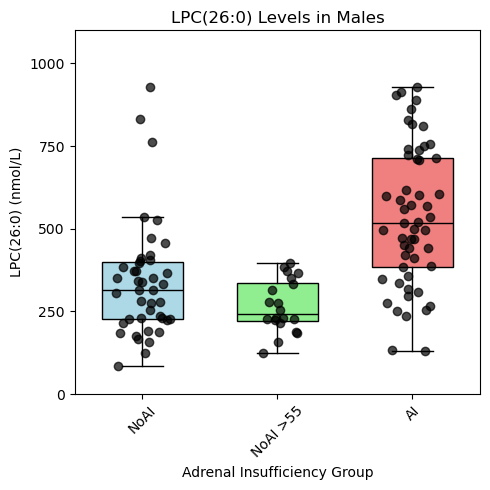

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))

box_colors = ['lightblue', 'lightgreen', 'lightcoral']
boxplot = ax.boxplot(grouped_data, positions=np.arange(len(group_order)), widths=0.6, patch_artist=True,
           boxprops=dict(facecolor="lightblue", color="black"),
           medianprops=dict(color="black"),
           whiskerprops=dict(color="black"),
           capprops=dict(color="black"),
           zorder=1,
            showfliers=False, )
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Add scatter points
for i, group in enumerate(grouped_data):
    x = np.random.normal(i, 0.1, size=len(group))  # Add jitter for better visibility
    ax.scatter(x, group, color='black', alpha=0.7, zorder=2)

ax.set_xticks(np.arange(len(group_order)))
ax.set_xticklabels(group_order, rotation=45)
ax.set_title('LPC(26:0) Levels in Males')
ax.set_xlabel('Adrenal Insufficiency Group')
ax.set_ylabel('LPC(26:0) (nmol/L)')
ax.set_yticks([0, 250, 500, 750, 1000])
ax.set_ylim([0, 1100])

# Tight layout
plt.tight_layout()
plt.show()

## Predicting Adrenal Insufficiency

In [6]:
male_data

,Sample ID,Group,LPC(26:0) (nmol/L)
1,MLPC_men_001,AI,567.564
2,MLPC_men_002,AI,928.313
3,MLPC_men_003,AI,902.946
4,MLPC_men_004,AI,749.672
5,MLPC_men_005,AI,741.871
...,...,...,...
96,MLPC_men_077,AI,451.271
97,MLPC_men_080,AI,468.237
98,MLPC_men_072,NoAI,525.412
101,MLPC_men_079,AI,586.476


In [7]:
X = male_data[["LPC(26:0) (nmol/L)"]]
y = male_data["Group"].apply(lambda x: 1 if x == "AI" else 0)

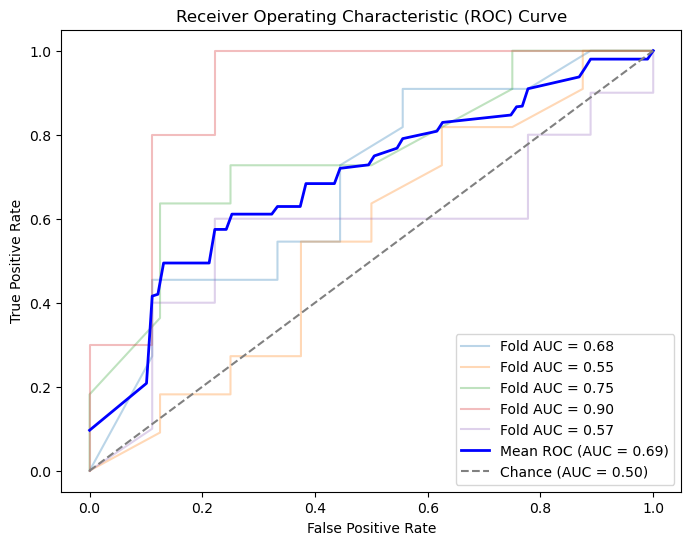

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

def evaluate_model(X, y, model):
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Lists to store ROC curve data
    mean_fpr = np.linspace(0, 1, 100)  # Fixed set of points for interpolation
    tprs = []  # True positive rates
    aucs = []  # Store AUC values
    
    plt.figure(figsize=(8, 6))  # Create plot
    
    # Cross-validation loop
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict probabilities for positive class
        y_probs = model.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        
        # Interpolate to create a smooth average ROC curve
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc)
        
        # Plot individual fold ROC
        plt.plot(fpr, tpr, alpha=0.3, label=f'Fold AUC = {roc_auc:.2f}')
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
    
    # Plot chance line
    plt.plot([0, 1], [0, 1], linestyle="--", color='grey', label="Chance (AUC = 0.50)")
    
    # Formatting the plot
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(X, y, rf_model)

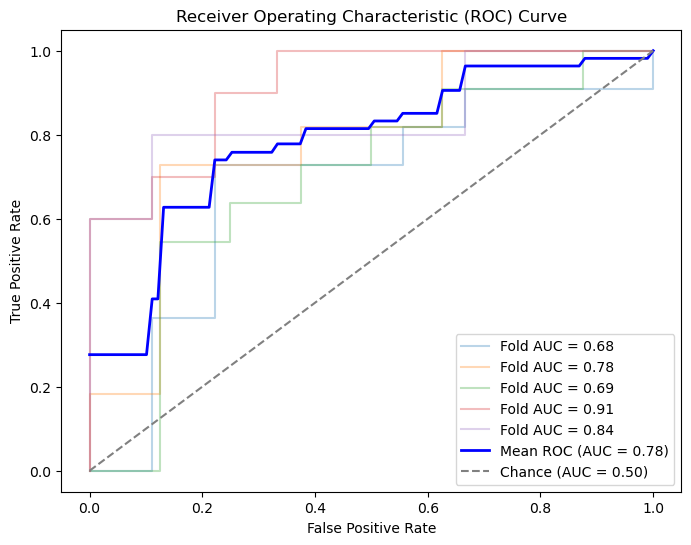

In [9]:
lr_model = LogisticRegression()
evaluate_model(X, y, lr_model)

/home/daniel/anaconda3/envs/ald/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


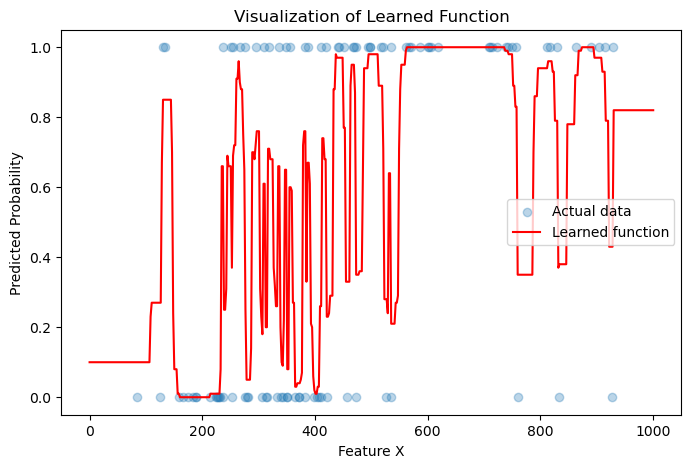

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_function(classifier):
    # Generate a range of values from 0 to 1000
    X_range = np.linspace(0, 1000, 500).reshape(-1, 1)
    
    # Fit the classifier on the training data
    classifier.fit(X, y)
    
    # Get predictions (probability of class 1)
    y_pred = classifier.predict_proba(X_range)[:, 1]
    
    # Plot the learned function
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, alpha=0.3, label="Actual data")  # Original data points
    plt.plot(X_range, y_pred, color='red', label="Learned function")  # Model prediction
    plt.xlabel("Feature X")
    plt.ylabel("Predicted Probability")
    plt.title("Visualization of Learned Function")
    plt.legend()
    plt.show()

plot_function(rf_model)

/home/daniel/anaconda3/envs/ald/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


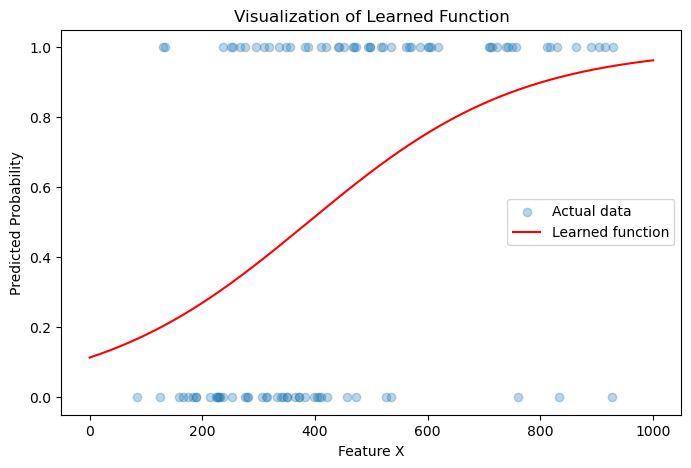

In [11]:
plot_function(lr_model)